<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/BLSTM_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Labelling with a Bidirectional Long Short Term Memory RNN

## Google Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device = torch.device(dev)  
#device = torch.device('cpu')  

CUDA available:  True


## Data loading

In [3]:
# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

In [4]:
# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Check number of phrases after splitting using the index array
data_set_train_phrases = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
data_set_test_phrases = np.split(data_set_test, data_end_index_test)[:-1]

print('Train: split data into {} phrases.'.format(len(data_set_train_phrases)))
print('Test: split data into {} phrases.'.format(len(data_set_test_phrases)))

Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [5]:
num_coef = 13

# Divide data into input (x) y output (y)
x_train = [data_set_train[:,:-1] for data_set_train in data_set_train_phrases]
y_train = [data_set_train[:,-1].transpose() for data_set_train in data_set_train_phrases]
x_test = [data_set_test[:,:-1] for data_set_test in data_set_test_phrases]
y_test = [data_set_test[:,-1].transpose() for data_set_test in data_set_test_phrases]

# Add batch dimension to inputs
# x_train = [x.reshape((1, -1, num_coef )) for x in x_train]
x_test = [x.reshape(1, -1, num_coef) for x in x_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Transform to tensor
x_train = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_train]
y_train = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_train]
x_test = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_test]
y_test = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Save in Device
x_train = [phrase.to(device) for phrase in x_train]
y_train = [phrase.to(device) for phrase in y_train]
x_test = [phrase.to(device) for phrase in x_test]
y_test = [phrase.to(device) for phrase in y_test]

# Get size of tran and test set
train_size = len(x_train)
test_size = len(x_test)

print("--Train data")
print("Number of samples: ", train_size)

print("--Test data")
print("Number of samples: ", test_size)

x_train shape:  (90, 13)
x_test shape:  (1, 129, 13)
x_train shape:  torch.Size([90, 13])
x_test shape:  torch.Size([1, 129, 13])
--Train data
Number of samples:  3696
--Test data
Number of samples:  192


## Define BLSTM Class

In [6]:
class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

  def forward(self, x, hidden=None, batch_mode=False):

    if hidden:  # Detach from their history
      hidden[0].detach_()
      hidden[1].detach_()


    if isinstance(x, list):
      batch_mode = True
    
    if batch_mode:
      seq_lengths = [sample.shape[0] for sample in x]  # get the length of each seq in your batch
      x_padded = torch.nn.utils.rnn.pad_sequence(x, batch_first=True)
      x_input = torch.nn.utils.rnn.pack_padded_sequence(x_padded, batch_first=True, lengths=seq_lengths, enforce_sorted=False)
      x_input.to(device)
    else:
      x_input = x

    out_lstm, (hn, cn) = self.lstm(x_input, hidden)

    if batch_mode:
      # unpack
      out_lstm, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out_lstm, batch_first=True)

    out = self.fc(out_lstm)
    


    hidden = (hn, cn)

    return out, hidden

  def init_hidden(self, x, batch_size): # Not used
    h0 = torch.randn(self.nr_layers*2, batch_size, self.hidden_size).requires_grad_().to(device)
    c0 = torch.randn(self.nr_layers*2, batch_size, self.hidden_size).requires_grad_().to(device)
    return (h0, c0)
    

## Instantiate BLSTM model

In [7]:
NR_PHONEMES = 61
input_size = num_coef  # Number of coefficients
hidden_size = 93  # Specified by Graves Is this ok
output_size = NR_PHONEMES  # Number of phonemes
layer_size = 2 

print("Creating BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

Creating BLSTM model with parameters:
Input size:  13
Hidden size:  93
Layer size:  2
Output size:  61


In [8]:
learning_rate = 10e-5 # Specified by Graves
momentum = 0.9

cost_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

## Testing pad sequences for forward()

In [40]:
model.train()

x_input = x_train[:32]
seq_lengths = [x.shape[0] for x in x_input]  # get the length of each seq in your batch
y_padded, _ = model(x_input, batch_mode=True)
y = torch.nn.utils.rnn.pad_sequence(y_train[:32], batch_first=True)

batch_loss = 0.0
batch_nr_correct_frames = 0
for i in range(y_padded.size(0)):
  ce_loss = cost_function(y_padded[i], y[i])
  #print(y_padded[i].shape)
  batch_loss += ce_loss
  
  seq_len = seq_lengths[i]
  #print("testing")
  #print(y_padded[i, :lenn].shape)
  #print(y[i, :lenn].shape)
  #print(y_train[i].shape)
  y_prediction = torch.argmax(y_padded[i,:seq_len], dim=1)
  
  batch_nr_correct_frames += int((y_prediction == y_train[i]).sum())

optimizer.zero_grad()
batch_loss.backward()
optimizer.step()

print('Loss is: ', batch_loss.item())
print('Correct frames in batch: ', batch_nr_correct_frames)


Loss is:  131.5528564453125
Correct frames in batch:  23


## Evaluate model in test data

In [9]:
def evaluate_model(model, input_data, labels):
  
  model.eval()
  
  total_loss = 0
  nr_correct_frames = 0
  nr_total_frames = 0
  
  hidden = None
  for (x_test_phrase, y_test_phrase) in zip(input_data, labels):
    #x_test_phrase = x_test_phrase.reshape(-1, x_test_phrase.size(0), input_size)
    output_test, _ = model(x_test_phrase, hidden)
    output_test = output_test[0] # Batch size is 1
    # Accumulate loss
    total_loss += cost_function(output_test, y_test_phrase)
  
    # Calculate number of correct frames
    y_prediction_test = torch.argmax(output_test, dim=1)
    nr_correct_frames += int((y_prediction_test == y_test_phrase).sum())
    nr_total_frames += len(y_test_phrase)
  
  # Arrange return values
  average_loss = total_loss/test_size
  average_loss = average_loss.item()
  
  perc_correct = nr_correct_frames/nr_total_frames*100
  
  return average_loss, perc_correct

In [10]:
print(x_test[0].shape)
print(y_test[0].shape)
average_loss, perc_correct = evaluate_model(model, x_test, y_test)


print('Loss:', average_loss)
print("Correct frames percentage: ", perc_correct)

torch.Size([1, 129, 13])
torch.Size([129])
Loss: 4.107912540435791
Correct frames percentage:  1.7196429496365615


In [12]:
def train_model(model, x_train, y_train, batch_size=1):
  model.train()

  train_size = len(x_train)
  # x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train, batch_first=True)
  hidden = None
  
  nr_correct_frames = 0
  nr_total_frames = 0
  epoch_total_loss = 0

  # Randomize the order of phrases for each epoch
  random_idxs = np.random.permutation(train_size)

  #for i in tqdm.notebook.tqdm(random_idxs):
  remaining_samples = True
  batch_init = 0
  
  if batch_size > 1:
    batch_mode = True
  else:
    batch_mode = False
  
  while remaining_samples:
    batch_end = min(batch_init+batch_size-1, train_size-1) # What to do with last batch if it is smaller?
    batch_idxs = random_idxs[batch_init:batch_end]
    batch_init += batch_size
    
    if batch_end >= train_size - 1:
      remaining_samples = False
    
    x_train_batch = [x_train[i] for i in batch_idxs]
    y_train_batch = [y_train[i] for i in batch_idxs]

    seq_lengths = [x.shape[0] for x in x_train_batch]  # get the length of each seq in your batch

    # At each batch, we detach the hidden state from how it was previously produced.
    # If we didn't, the model would try backpropagating all the way to the start of the dataset.
    model.zero_grad()

    # Forward pass
    # y_pred, hidden = model(x_train[i], hidden)
    y_padded, hidden = model(x_train_batch, hidden) # TODO: hacer que se vaya corriendo

    # Compute loss
    batch_loss = 0.0
    for i in range(y_padded.size(0)):
      #print("y_padded: ", y_padded.shape)
      #print("y_train_batch: ", y_train_batch[i].shape)
      seq_len = seq_lengths[i]
      y_unpadded = y_padded[i,:seq_len]
      ce_loss = cost_function(y_unpadded, y_train_batch[i])
      batch_loss += ce_loss

      y_pred_labels = torch.argmax(y_unpadded, dim=1)
      nr_correct_frames += int((y_pred_labels == y_train_batch[i]).sum())
      nr_total_frames += len(y_train_batch[i])

    epoch_total_loss += batch_loss.item()

    # Backward pass
    optimizer.zero_grad() # Clear grads before doing backward
    batch_loss.backward()
    optimizer.step()
  
    # Epoch training results
    epoch_loss_train = epoch_total_loss/train_size
    perc_correct_train = nr_correct_frames/nr_total_frames*100

  return epoch_loss_train, perc_correct_train

### Training time

In [13]:
import time

nr_epochs = 30
epoch_losses_train = []
epoch_losses_test = []
epoch_correct_frames_train = []
epoch_correct_frames_test = []
BATCH_SIZE = 64

start_time = time.time()
# TODO: initial weights? Graves: from flat distribution between -0.1 and 0.1
for epoch in range(nr_epochs):
  print(f'EPOCH #{epoch+1}')
  #========= Train ==============#
  epoch_loss_train, perc_correct_train = train_model(model, x_train, y_train, batch_size=BATCH_SIZE)
  
  print('Train loss:', epoch_loss_train)
  print("Correct frames percentage: ", perc_correct_train)

  # =====See test results========#
  epoch_loss_test, perc_correct_test = evaluate_model(model, x_test, y_test)
  print('Test loss:', epoch_loss_test)
  print("Correct frames percentage: ", perc_correct_test)

  # Append epoch results 
  epoch_losses_train.append(epoch_loss_train)
  epoch_losses_test.append(epoch_loss_test)
  epoch_correct_frames_train.append(perc_correct_train)
  epoch_correct_frames_test.append(perc_correct_test)

  print()


print('Done training')
print()
end_time = time.time()

duration = end_time - start_time

print(f'Total training time: {duration} seconds')

EPOCH #1
Train loss: 3.986890549267525
Correct frames percentage:  9.961496398195935
Test loss: 3.9723870754241943
Correct frames percentage:  12.773010583746267

EPOCH #2
Train loss: 3.8265894935244607
Correct frames percentage:  12.613995754267396
Test loss: 3.8030030727386475
Correct frames percentage:  12.773010583746267

EPOCH #3
Train loss: 3.6616452039578262
Correct frames percentage:  12.615342625211706
Test loss: 3.6636712551116943
Correct frames percentage:  12.773010583746267

EPOCH #4
Train loss: 3.539853203348267
Correct frames percentage:  12.75234777832781
Test loss: 3.5557079315185547
Correct frames percentage:  13.638011706003212

EPOCH #5
Train loss: 3.43011508049903
Correct frames percentage:  14.793132060327668
Test loss: 3.450294256210327
Correct frames percentage:  15.899791087553309

EPOCH #6
Train loss: 3.3209218772458824
Correct frames percentage:  16.745739203302808
Test loss: 3.346919059753418
Correct frames percentage:  17.522747285001465

EPOCH #7
Train los

In [14]:
# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 
                           'loss_test': epoch_losses_test, 
                           'correct_frames_train': epoch_correct_frames_train, 
                           'correct_frames_test': epoch_correct_frames_test, 
                           'trainig_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/BLSTM/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + '_2ndtry_' + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'
torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

In [15]:
# Load model
model = torch.load(model_filepath, map_location=device)
epoch_info = pd.read_csv(epoch_info_filepath)

### See Loss after training

In [16]:
# See the loss after training
after_train_loss, after_train_perc_correct = evaluate_model(model, x_test, y_test)

print('After train Loss:', after_train_loss)
print("Correct frames percentage: ", after_train_perc_correct)

After train Loss: 2.252612829208374
Correct frames percentage:  39.14086914484021


## Plots

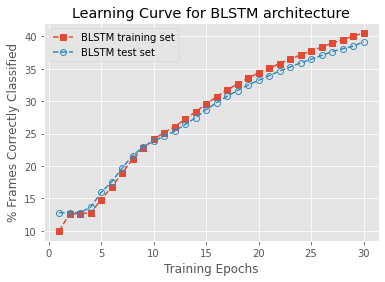

In [17]:
# Learning Curve

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()
epochs = np.arange(1,nr_epochs+1)
ax.plot(epochs, epoch_info['correct_frames_train'], '--s', label='BLSTM training set')
ax.plot(epochs, epoch_info['correct_frames_test'], '--o', markerfacecolor='None', label='BLSTM test set')

training_time = epoch_info['trainig_duration'][0]
ax.set(xlabel='Training Epochs', ylabel='% Frames Correctly Classified',
       title='Learning Curve for BLSTM architecture')

learning_curve_filepath = root_path +'learning_curve_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

